In [18]:
import os
import warnings
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import resample

import config

np.random.seed(42)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

In [91]:
# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

def randomForest_gridsearch(dataFile, modelTarget, param_grid, features, upsample=False):
    logger.info("randomForest_gridsearch(dataFile={df}, modelTarget={mt})".format(df=dataFile, mt=modelTarget))

    samples = pd.read_excel(dataFile)
    samples = samples.rename(index=str,
                             columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})

    names = features

    samples_split = []
    if (modelTarget == "presence"):
        samples_split.append(samples[samples.PresenceClass == 1])
        samples_split.append(samples[samples.PresenceClass == 2])
        samples_split.append(samples[samples.PresenceClass == 3])

    elif (modelTarget == "copresence"):
        samples_split.append(samples[samples.CopresenceClass == 1])
        samples_split.append(samples[samples.CopresenceClass == 2])
        samples_split.append(samples[samples.CopresenceClass == 3])
    else:
        sys.exit("Invalid input. Please pick between presence and copresence")

    maxClassSize = max(samples_split[0].shape[0], samples_split[1].shape[0], samples_split[2].shape[0])

    if upsample:
        upsampled = []
        # todo upsample with SMOTE algorithm ? https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
        for idx, samples in enumerate(samples_split):
            if (samples.shape[0] == maxClassSize):
                upsampled.append(samples)
            else:
                logger.debug("resample: adding " + str(maxClassSize - samples.shape[0]) + " samples to class " + str(
                    idx + 1) + " to reach " + str(maxClassSize))
                upsampled.append(resample(samples, replace=True, n_samples=maxClassSize, random_state=None))

        balanced_set = pd.concat(upsampled)
        X = np.nan_to_num(balanced_set.as_matrix(names))

        if (modelTarget == "presence"):
            y = np.array(balanced_set["PresenceClass"].tolist())

        else:
            y = np.array(balanced_set["CopresenceClass"].tolist())

    else:

        X = np.nan_to_num(samples[list(names)])
        if modelTarget == "presence":
            y = samples.PresenceClass
        else:
            y = samples.CopresenceClass

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #logger.debug("X_train ", X_train.shape, "X_test", X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)

    forest = RandomForestClassifier(n_estimators=10)

    # print X.shape
    print(modelTarget + " random forest")
  # todo move to beginning with other imports

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))

    grid = GridSearchCV(estimator=forest, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='precision_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=1)

    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# RandomForestClassifier
## Subject + phases split (0.15, 0.70, 0.15)

In [115]:
matrix = os.path.join(os.path.dirname(config.CORPUS_PATH), 'matrix-2019-0226_15-16-44Features-157015.xlsx')

n_estimators = [10, 20, 30, 40, 50, 100, 1000]
class_weights = [None, 'balanced', 'balanced_subsample']
max_features = [None, 'auto', 'sqrt', 'log2']
param_grid =  {
    'n_estimators': n_estimators,
    'class_weight': class_weights
    #'max_features': [None, 'auto', 'sqrt', 'log2']
}
grid = randomForest_gridsearch(matrix, 'presence', param_grid=param_grid, features=subject_features, upsample=True)

c:\python27\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


presence random forest
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.2min finished
c:\python27\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [116]:
print("Best %f for params %s" % (grid.best_score_, grid.best_params_))

Best 0.833183 for params {'n_estimators': 100, 'class_weight': None}


In [117]:
print(pd.DataFrame(data=grid.cv_results_)[['mean_test_precision_macro', 'param_n_estimators', 'param_class_weight']])
scores = pd.DataFrame(data=grid.cv_results_['mean_test_precision_macro'].reshape(len(class_weights), len(n_estimators)))
print(scores)

    mean_test_precision_macro param_n_estimators  param_class_weight
0                    0.752724                 10                None
1                    0.756306                 20                None
2                    0.787109                 30                None
3                    0.743844                 40                None
4                    0.785564                 50                None
5                    0.833183                100                None
6                    0.800751               1000                None
7                    0.704955                 10            balanced
8                    0.745946                 20            balanced
9                    0.775526                 30            balanced
10                   0.772673                 40            balanced
11                   0.776298                 50            balanced
12                   0.766688                100            balanced
13                   0.773724     

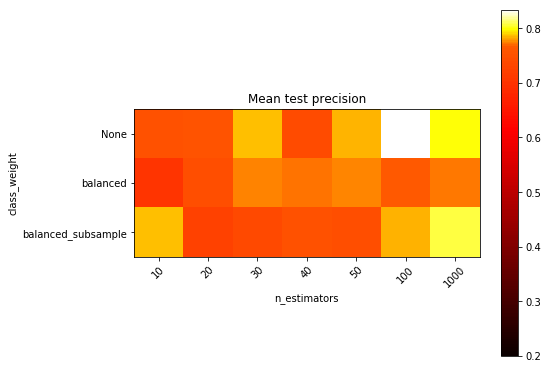

In [121]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Plotting Function
def plot_gscv(scores, param_1, param_2, label_1, label_2, label):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=np.array(scores).mean()))
    plt.xlabel(label_1)
    plt.ylabel(label_2)
    plt.colorbar()
    plt.xticks(np.arange(len(param_1)), param_1, rotation=45)
    plt.yticks(np.arange(len(param_2)), param_2)
    plt.title(label)
    plt.show()
    
plot_gscv(scores, n_estimators, class_weights, 'n_estimators', 'class_weight', 'Mean test precision')

In [113]:
print(np.array(scores).mean())

0.8292453167453168


In [124]:
param_grid =  {
    'n_estimators': n_estimators,
    'max_features': max_features
}
grid = randomForest_gridsearch(matrix, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
print("Best test precision score for params %s" % (grid.best_params_))




c:\python27\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


presence random forest
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Best test precision score for params {'max_features': 'log2', 'n_estimators': 100}
<built-in function max>


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  1.6min finished
c:\python27\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NameError: name 'some_value' is not defined

In [128]:
df = pd.DataFrame(grid.cv_results_)
best_precision = df.mean_test_precision_macro.max()
best_f1 = df.mean_test_f1_macro.max()
best_recall = df.mean_test_recall_macro.max()
print(best_precision)
df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
df_best[['params', 'mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro']]

0.8355855855855856


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Agent + phases split(0.15, 0.70, 0.15)

## Subject + no phase split

## Agent + no phase split

## Subject + Agent + phases split (0.15, 0.70, 0.15)

## Subject + Agent + no phase split